## Portfolio Analysis Notebook: A Complete Guide to Modern Portfolio Theory

This notebook demonstrates a comprehensive portfolio analysis system that implements multiple optimization strategies from Modern Portfolio Theory (MPT). We'll walk through various portfolio allocation methods, compare their performance, and recommend the optimal strategy.

## **What This Notebook Does**

This analysis implements and compares **5 different portfolio optimization strategies**:
1. **User-Defined Allocation** (baseline)
2. **Risk Parity** (equal risk contribution)
3. **Beta-Weighted** (inverse volatility weighting)
4. **Sharpe Ratio Optimization** (Monte Carlo simulation)
5. **Markowitz Optimization** (efficient frontier)

## **End-to-End Workflow**

```
Input Portfolio → Historical Data → Calculate Returns → 
Apply 5 Strategies → Simulate Performance → Select Best Strategy
```

---

**Note:** This version is adapted for Jupyter notebooks. UI elements like buttons or input forms have been removed. Instead, values are assigned directly for demonstration purposes.


In [2]:
%matplotlib inline

from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize

# Import core functions from project modules (ensure the project is in PYTHONPATH or use relative imports)
from app.config.config import (
    HISTORICAL_PERIOD_DAYS, BENCHMARK_TICKER,
    PORTFOLIO_EVOLUTION_YEARS, TARGET_MARKET_BETA,
    NUMBER_OF_PORTFOLIOS)
from app.visualization.visuals import (
    create_pie_chart, plot_historical_prices, plot_daily_returns,
    plot_portfolio_returns, plot_portfolio_evolution, plot_sharpe_ratio_scatter,
    plot_efficient_frontier
)
from app.analysis.portfolio_analyzer import PortfolioAnalyzer

## Step 1: Define Portfolio Inputs

### **What We're Doing Here**
We start by defining our baseline portfolio - this represents what a typical investor might choose based on intuition or basic research. This will serve as our **benchmark** against which we'll compare all optimized strategies.

### **Key Concepts**
- **Portfolio Weights**: The percentage of total investment allocated to each stock
- **Diversification**: Spreading risk across multiple assets
- **Asset Selection**: Choosing stocks from different sectors/market caps

In [ ]:
# Simulated user portfolio (example)
amount = 10000  # Total investment amount

# User's tickers and their allocations (as percentages)
# This represents a typical tech-heavy portfolio
ticker_percentage = {
    'AAPL': 0.4,   # 40% Apple - Large cap tech
    'MSFT': 0.3,   # 30% Microsoft - Cloud/software leader  
    'GOOGL': 0.3   # 30% Google - Digital advertising leader
}

tickers = list(ticker_percentage.keys())
weights = list(ticker_percentage.values())
num_tickers = len(tickers)

print(f" Analyzing portfolio with {num_tickers} assets:")
for ticker, weight in ticker_percentage.items():
    print(f"   {ticker}: {weight:.1%}")

📊 Analyzing portfolio with 3 assets:
   AAPL: 40.0%
   MSFT: 30.0%
   GOOGL: 30.0%


## Step 2: Define Date Range

### **Historical Analysis Period**
We use historical data to understand how our assets have performed in the past. This historical performance helps us:
- Calculate **volatility** (risk) of each asset
- Understand **correlations** between assets
- Estimate future **expected returns**
- Compute **beta coefficients** (systematic risk)

### **Important Note**
Past performance doesn't guarantee future results, but it's the best available data for statistical analysis.

In [ ]:
end_date = datetime.today().date()
start_date = end_date - timedelta(days=HISTORICAL_PERIOD_DAYS)
print(f" Analysis Period: {start_date} to {end_date}")
print(f" Total Days: {HISTORICAL_PERIOD_DAYS} days (~{HISTORICAL_PERIOD_DAYS/365:.1f} years)")

📅 Analysis Period: 2024-07-01 to 2025-07-01
📊 Total Days: 365 days (~1.0 years)


## Step 3: Load Historical Prices

### **Data Collection Process**
We fetch **adjusted closing prices** for our selected stocks. Adjusted prices account for:
- **Stock splits** (when 1 share becomes 2+ shares)
- **Dividends** (cash payments to shareholders)
- **Special distributions**

### **Technical Implementation**
The function handles both single and multiple ticker queries, managing Yahoo Finance's different data formats automatically.

In [5]:
def get_historical_prices(tickers, start_date, end_date):
    """
    Fetch historical adjusted closing prices for given tickers.
    
    Why Adjusted Close?
    - Accounts for stock splits and dividends
    - Provides accurate historical returns
    - Essential for proper portfolio analysis
    """
    data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', auto_adjust=False)

    if data.empty:
        print("❌ Yahoo Finance returned empty data. Please check ticker symbols and try again.")
        return None

    # Handle MultiIndex data (multiple tickers)
    if isinstance(data.columns, pd.MultiIndex):
        try:
            adj_close = data.xs('Adj Close', level=1, axis=1)
            return adj_close
        except KeyError:
            print("❌ No 'Adj Close' data found in MultiIndex columns.")
            return None

    # Handle flat DataFrame (single ticker)
    if 'Adj Close' in data.columns:
        return pd.DataFrame(data['Adj Close'])

    print("❌ Unexpected data format from Yahoo Finance.")
    return None

In [ ]:
prices = get_historical_prices(tickers, start_date, end_date)
print(f" Successfully loaded {len(prices)} days of price data")
print(f" Data shape: {prices.shape}")
prices.head()

[*********************100%***********************]  3 of 3 completed

✅ Successfully loaded 250 days of price data
📊 Data shape: (250, 3)


Ticker,GOOGL,AAPL,MSFT
Date,,,
2024-07-01,182.107864,215.741043,453.254944
2024-07-02,184.347000,219.244659,455.785522
2024-07-03,184.924210,220.518692,457.264160
2024-07-05,189.681183,225.286407,464.002533
2024-07-08,188.118729,226.759521,462.692566


## Step 4: Plot Historical Prices

### **Price Trend Visualization**
This visualization helps us understand:
- **Trend direction**: Are prices generally rising or falling?
- **Volatility patterns**: How much do prices fluctuate?
- **Correlation insights**: Do stocks move together or independently?
- **Major events**: Can we spot market crashes or booms?

### **What to Look For**
- **Parallel movements** = High correlation
- **Steep rises/falls** = High volatility periods
- **Diverging trends** = Diversification benefits

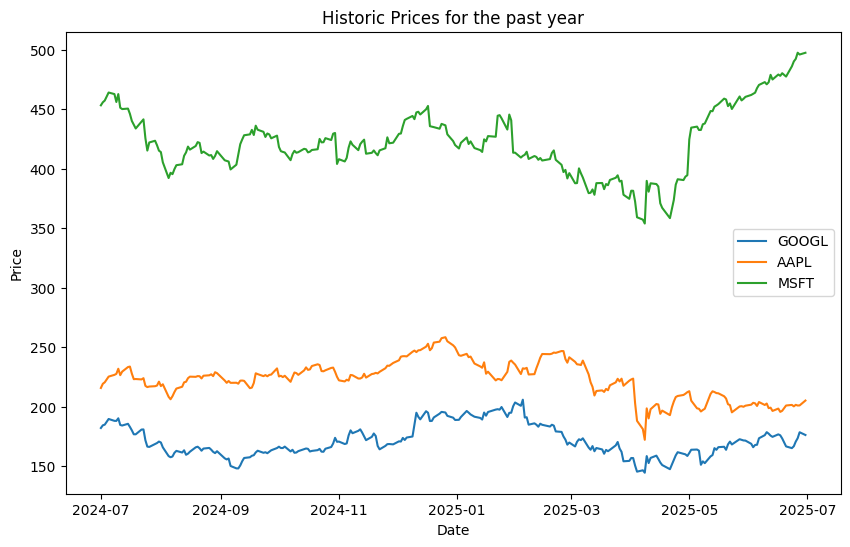

In [7]:
plot_historical_prices(prices)

## Step 5: Calculate Daily Returns

### **From Prices to Returns**
**Returns** are more important than absolute prices for portfolio analysis because:
- Returns are **comparable** across different price levels
- Returns show **percentage changes** (what investors care about)
- Returns can be **aggregated** to calculate portfolio performance
- Statistical models work better with **stationary** return data

### **The Math**
Daily Return = (Today's Price - Yesterday's Price) / Yesterday's Price

Or in percentage: `(P_t / P_{t-1}) - 1`

In [8]:
def get_daily_returns(price):
    """
    Calculate daily percentage returns from price data.
    
    Formula: (Price_today / Price_yesterday) - 1
    
    Why daily returns?
    - Standardizes different assets for comparison
    - Essential for risk calculations (volatility)
    - Required for correlation analysis
    - Foundation for all portfolio optimization
    """
    returns = price.pct_change()
    return returns

In [40]:
daily_returns = get_daily_returns(prices)
daily_returns.head()

Ticker,GOOGL,AAPL,MSFT
Date,,,
2024-07-01,NaN,NaN,NaN
2024-07-02,0.012296,0.016240,0.005583
2024-07-03,0.003131,0.005811,0.003244
2024-07-05,0.025724,0.021620,0.014736
2024-07-08,-0.008237,0.006539,-0.002823


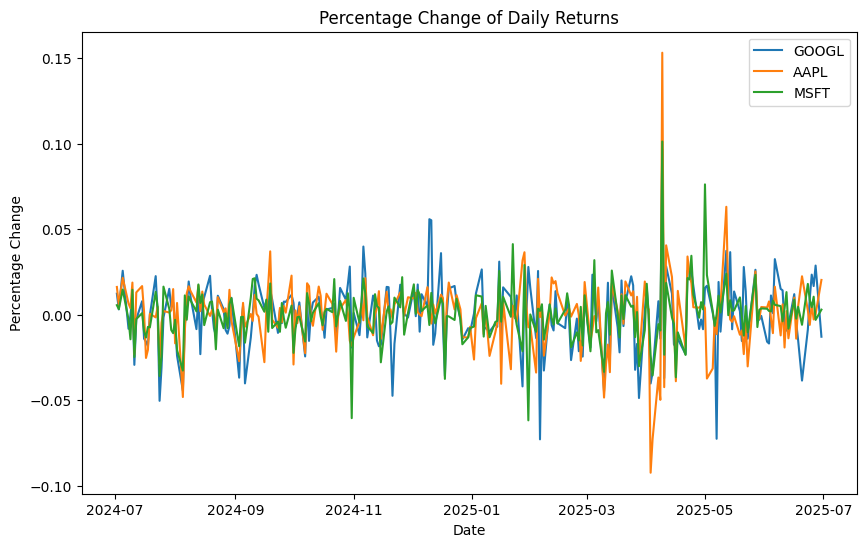

In [41]:
plot_daily_returns(daily_returns)

## Step 6: Portfolio Daily Returns

### **Creating a Composite Portfolio**
Now we combine individual stock returns into a **single portfolio return** using our defined weights. This is the foundation of portfolio analysis.

### **The Mathematics**
**Portfolio Return** = Σ (Weight_i × Return_i)

For our example:
- Portfolio Return = 40% × AAPL_return + 30% × MSFT_return + 30% × GOOGL_return

### **Why This Matters**
- Shows **actual portfolio performance** day by day
- Enables **risk measurement** (portfolio volatility)
- Foundation for **strategy comparison**
- Required for **optimization algorithms**

In [11]:
def get_portfolio_returns(weights, daily_returns):
    """
    Calculate portfolio daily returns using weighted average.
    
    This is the core of Modern Portfolio Theory:
    Portfolio Return = Sum of (Weight × Individual Return)
    
    The magic of diversification happens here:
    - Individual stocks may be volatile
    - Portfolio can be more stable than components
    - Correlation matters more than individual risk
    """
    portfolio_returns = daily_returns.dot(weights)
    return portfolio_returns

In [38]:
port_daily_return = get_portfolio_returns(weights, daily_returns)
port_daily_return.head()

Date
2024-07-01         NaN
2024-07-02    0.011465
2024-07-03    0.003969
2024-07-05    0.021197
2024-07-08   -0.002180
dtype: float64

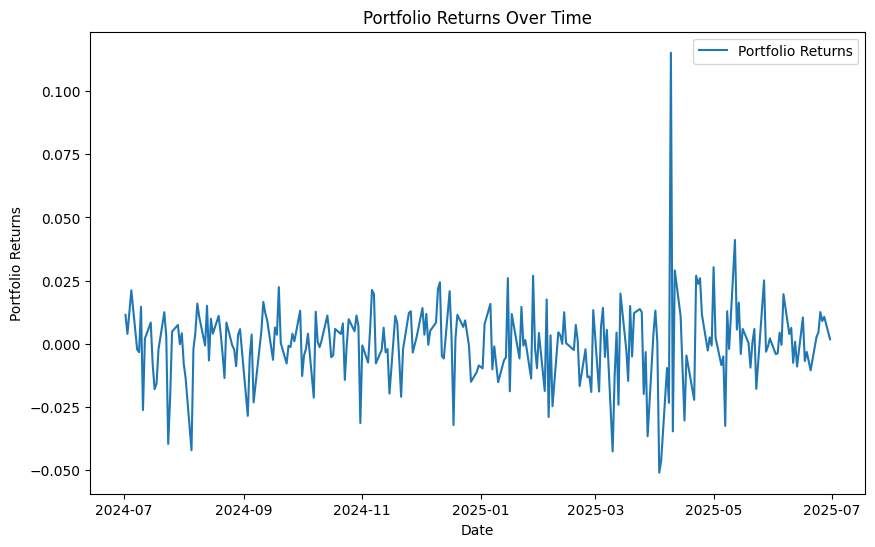

In [39]:
plot_portfolio_returns(port_daily_return)

# PORTFOLIO OPTIMIZATION STRATEGIES

Now we enter the core of portfolio optimization. We'll implement **5 different strategies**, each with its own philosophy and mathematical approach.

---

## Step 7: Beta Coefficients - Measuring Systematic Risk

### **What is Beta?**
**Beta (β)** measures how much a stock moves relative to the overall market:
- **β = 1.0**: Stock moves exactly with the market
- **β > 1.0**: Stock is more volatile than market (amplifies moves)
- **β < 1.0**: Stock is less volatile than market (dampens moves)
- **β < 0**: Stock moves opposite to market (rare)

### **The Mathematics**
**Beta = Covariance(Stock, Market) / Variance(Market)**

### **Why Beta Matters**
- **Risk Management**: High-beta stocks add more market risk
- **Market Timing**: Beta helps predict how stocks react to market moves
- **Portfolio Construction**: We can target specific market exposure
- **Systematic vs Unsystematic Risk**: Beta captures systematic (market) risk

### **Strategy Preview**
We'll use beta to create **inverse volatility weights** - giving less weight to high-beta (risky) stocks.

In [42]:
def get_benchmark_data(start_date, end_date):
    """
    Get benchmark (S&P 500) data for beta calculations.
    
    Why S&P 500?
    - Represents broad US market
    - Standard benchmark for beta calculation
    - Most liquid and tracked index
    - Contains our portfolio stocks (reduces noise)
    """
    benchmark_prices = get_historical_prices(BENCHMARK_TICKER, start_date, end_date)
    
    if benchmark_prices is None:
        print("Benchmark prices could not be retrieved.")
        return None

    benchmark_daily_returns = get_daily_returns(benchmark_prices)

    if benchmark_daily_returns is None or benchmark_daily_returns.empty:
        print("Benchmark daily returns could not be computed.")
        return None

    return benchmark_daily_returns.iloc[:, 0]

In [43]:
def calculate_beta(daily_returns, benchmark_returns):
    """
    Calculate Beta coefficient for each stock vs benchmark.
    
    Beta Interpretation:
    - β = 1.0: Perfect correlation with market
    - β = 1.5: 50% more volatile than market
    - β = 0.5: 50% less volatile than market
    
    High Beta = High Risk = High Potential Return
    Low Beta = Low Risk = Lower Potential Return
    """
    beta_list = {}
    
    # Calculate beta for each stock
    for ticker in daily_returns:
        # Covariance: How stock and market move together
        covariance = daily_returns[ticker].cov(benchmark_returns)
        
        # Variance: How much market moves on its own
        variance = benchmark_returns.var()
        
        # Beta: Systematic risk relative to market
        beta = covariance / variance
        
        beta_list[ticker] = beta
    
    beta_series = pd.Series(beta_list, name='Beta')
    
    return beta_series

In [44]:
benchmark_daily_returns = get_benchmark_data(start_date, end_date)
betas = calculate_beta(daily_returns, benchmark_daily_returns)
betas

[*********************100%***********************]  1 of 1 completed


GOOGL    1.053711
AAPL     1.238058
MSFT     0.970007
Name: Beta, dtype: float64

## Step 8: Beta-Weighted Strategy 

###  **Strategy Philosophy**
The **Beta-Weighted Strategy** aims to create a portfolio with a **target market beta** by adjusting weights inversely to individual stock betas.

###  **The Algorithm**
For each stock: **Weight = (Target_Beta - Stock_Beta) / (Sum_All_Betas - Stock_Beta)**

###  **Strategic Logic**
- **High Beta stocks** get **lower weights** (reduce risk)
- **Low Beta stocks** get **higher weights** (stable foundation)
- **Target result**: Portfolio beta close to desired level (usually 1.0)

###  **Advantages**
- **Risk Control**: Manages systematic risk exposure
- **Market Timing**: Can adjust market sensitivity
- **Downside Protection**: Reduces losses in market downturns

###  **Limitations**
- May **reduce upside** potential in bull markets
- **Beta instability**: Betas change over time
- Only addresses **systematic risk**, not total risk

In [49]:
def calculate_beta_weights(data):
    """
    Calculate portfolio weights inversely proportional to beta.
    
    Goal: Create portfolio with target market beta
    Method: Give lower weights to high-beta (risky) stocks
    
    This is a risk management technique:
    - Reduces portfolio volatility
    - Provides more stable returns
    - Maintains market exposure at desired level
    """
    if isinstance(data, pd.Series):
        # If input is a Series, create a DataFrame with one column
        df = pd.DataFrame(data, columns=['Beta'])
    else:
        # If input is already a DataFrame, use it directly
        df = data

    beta_weights = {}
    target_market_beta = TARGET_MARKET_BETA
    sum_of_all_stock_betas = df['Beta'].sum()
    
    for index, row in df.iterrows():
        numerator = target_market_beta - row['Beta']
        denominator = sum_of_all_stock_betas - row['Beta']
        stock_weight = numerator / denominator
        beta_weights[index] = stock_weight
        
    beta_weights_df = pd.DataFrame.from_dict(beta_weights, orient='index', columns=['Weight'])
    beta_weights_df_normalized = beta_weights_df['Weight'] / beta_weights_df['Weight'].sum()
    
    return beta_weights_df_normalized

In [50]:
beta_weight = calculate_beta_weights(betas)
beta_weight

GOOGL    0.188752
AAPL     0.912800
MSFT    -0.101552
Name: Weight, dtype: float64

## Step 9: Risk Parity Weights

### What is Risk Parity?

**Risk Parity** is a portfolio allocation strategy that aims to equalize the **risk contribution** of each asset in the portfolio, rather than equalizing the dollar amounts invested in each asset.

### Key Concepts:

1. **Traditional Equal Weighting**: If you have 3 stocks, you might invest 33.33% in each. However, if one stock is much more volatile than the others, it will dominate your portfolio's risk.

2. **Risk Parity Approach**: Instead of equal dollar amounts, we allocate based on risk. Assets with higher volatility get smaller weights, and assets with lower volatility get larger weights.

### Mathematical Foundation:

- **Asset Volatility**: We calculate the standard deviation of each asset's returns
- **Risk Contribution**: Each asset's volatility as a proportion of total portfolio volatility
- **Target Risk Allocation**: We want each asset to contribute equally to risk (1/n for n assets)
- **Weight Calculation**: `Weight = Target Risk / Asset's Risk Contribution`

### Benefits:
- **Diversification**: Prevents any single asset from dominating portfolio risk
- **Stability**: Often results in more stable returns over time
- **Risk Management**: Systematic approach to managing portfolio risk

### Example:
If Stock A has volatility of 20% and Stock B has volatility of 10%, Stock A will receive a smaller weight because it's riskier.

In [53]:
def calculate_risk_parity_weights(returns):
    """Risk Parity: invest such a way that every asset we have in the portfolio has the same risk contribution"""
    # Step 1: Calculate asset volatilities (standard deviation of returns)
    # Higher volatility = higher risk
    asset_volatility = returns.std(axis=0)

    # Step 2: Calculate each asset's risk contribution
    # This shows how much each asset contributes to total portfolio risk
    asset_risk_contribution = asset_volatility / asset_volatility.sum()

    # Step 3: Determine target risk allocation
    # We want each asset to contribute equally to risk
    target_risk_allocation = 1 / len(asset_volatility)

    # Step 4: Calculate weights inversely proportional to risk
    # Assets with higher risk get lower weights
    weights = target_risk_allocation / asset_risk_contribution

    # Step 5: Normalize weights to sum to 1 (100%)
    weights /= weights.sum()

    return weights

In [54]:

risk_parity_weights = calculate_risk_parity_weights(daily_returns)
risk_parity_weights


Ticker
GOOGL    0.306979
AAPL     0.306437
MSFT     0.386583
dtype: float64

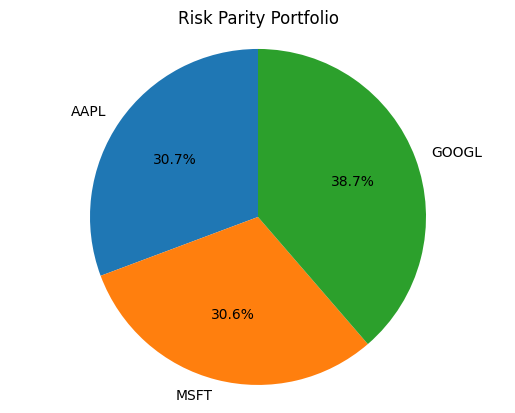

In [21]:

create_pie_chart(risk_parity_weights, tickers, 'Risk Parity Portfolio')


## Step 10: Portfolio Strategy Analysis Framework

### What is the PortfolioAnalyzer?

The `PortfolioAnalyzer` is a comprehensive tool that simulates how different portfolio allocation strategies would have performed over historical periods. It's like a time machine that shows you "what if" scenarios.

### Key Functions:

1. **Historical Performance Simulation**: Takes a set of weights and simulates portfolio performance over a specified time period
2. **Strategy Comparison**: Allows us to compare multiple allocation strategies side-by-side
3. **Total Return Calculation**: Computes the cumulative return for each strategy
4. **Performance Visualization**: Creates charts showing portfolio value evolution over time

### How It Works:

1. **Data Collection**: Fetches historical price data for the specified time period
2. **Weight Application**: Applies the given weights to calculate daily portfolio returns
3. **Compounding**: Compounds returns over time to show portfolio value growth
4. **Comparison**: Stores results for each strategy to enable comparison

### Why This Matters:

- **Evidence-Based Decisions**: Shows which strategies worked best historically
- **Risk Assessment**: Reveals volatility and drawdowns of different approaches
- **Strategy Validation**: Tests theoretical concepts against real market data

In [22]:

analyzer = PortfolioAnalyzer(tickers)


### Analyze User Strategy

This is our **baseline strategy** - the original portfolio allocation that the user specified. We simulate how this portfolio would have performed over the past 10 years.

**Purpose**: 
- Establish a benchmark for comparison
- Show the historical performance of the user's intuitive allocation
- Provide context for evaluating other strategies

**What We're Measuring**:
- Total return over the specified period
- Portfolio value evolution over time
- Volatility and risk characteristics

[*********************100%***********************]  3 of 3 completed
d:\WORK_DIRECTORY\Roboport\app\analysis\portfolio_analyzer.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = (portfolio_value['Profit Close'][-1]/portfolio_value['Profit Close'][0])-1


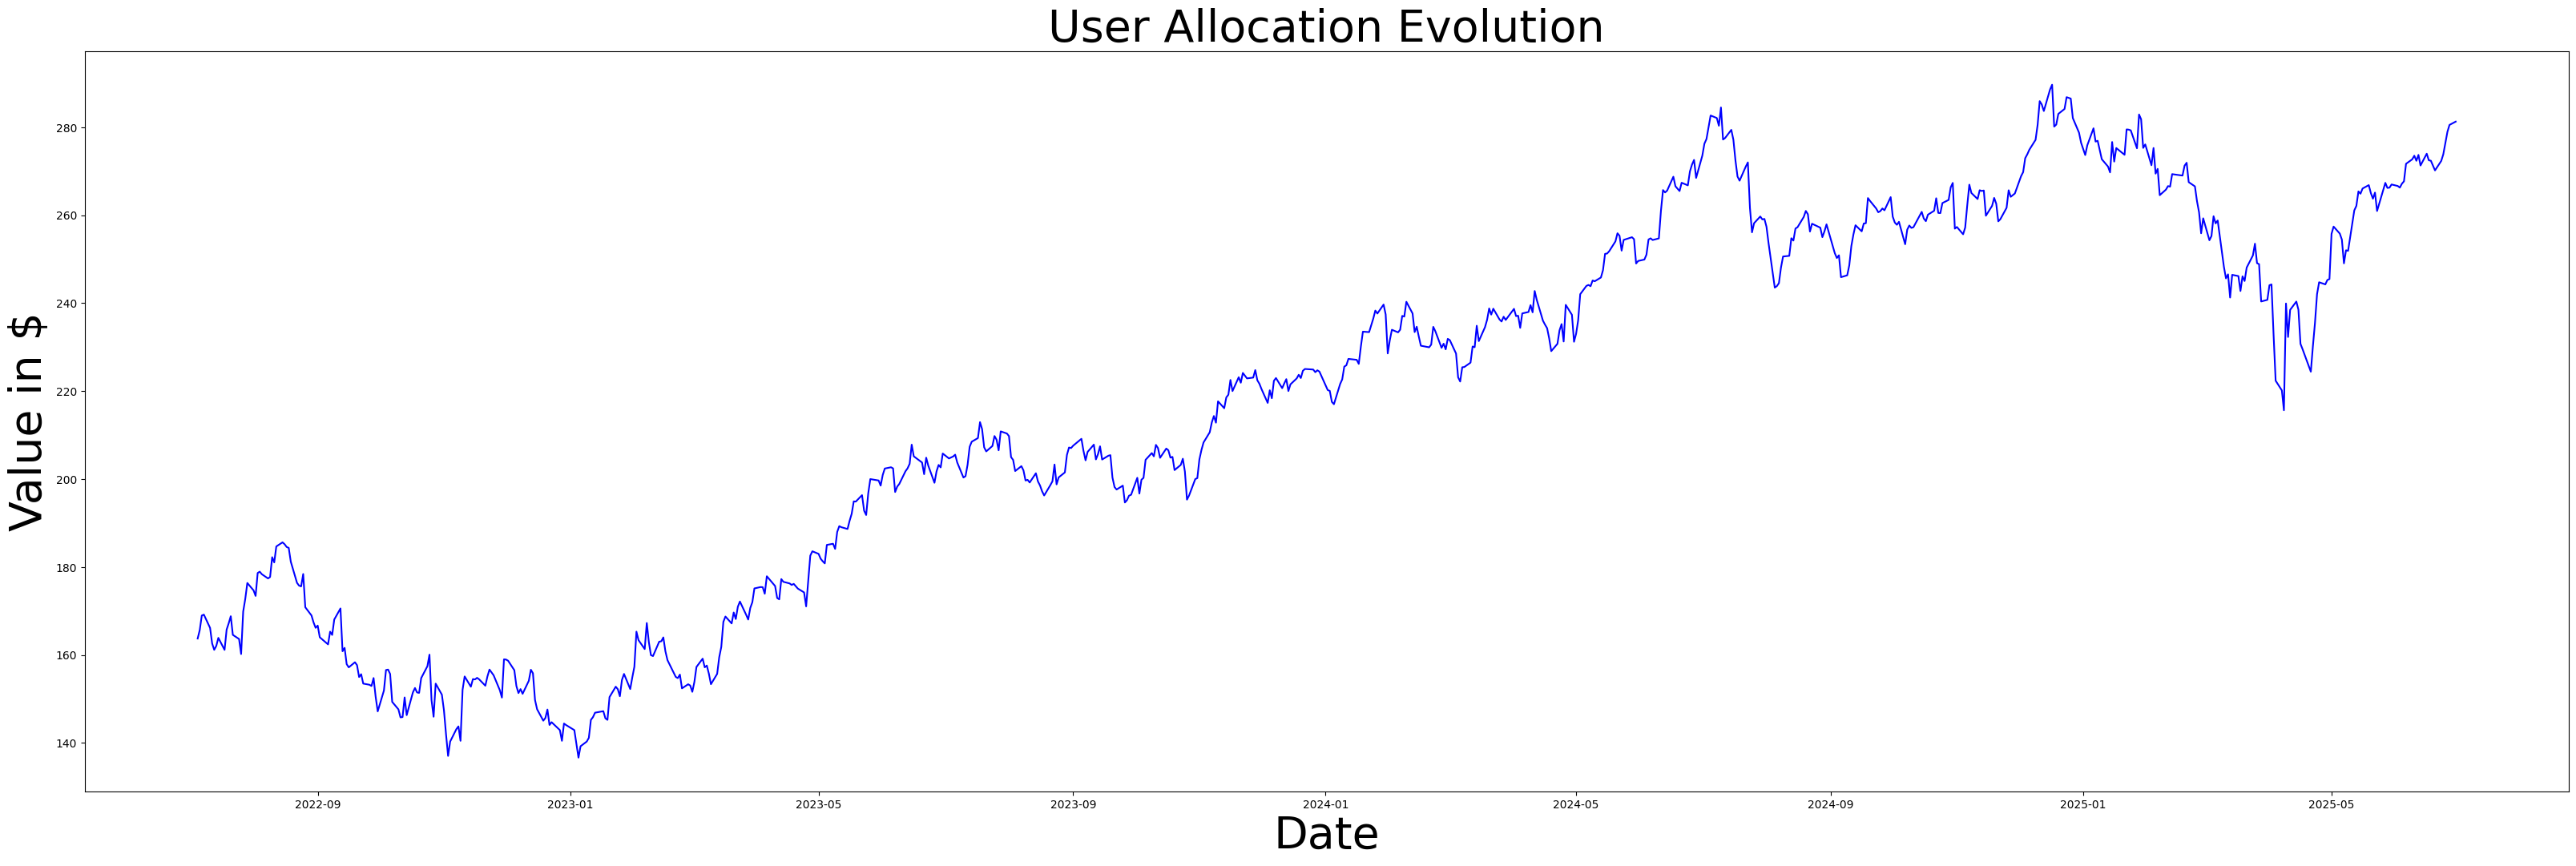

Total Return: 71.78%


In [23]:

user_value, user_return = analyzer.analyze_strategy('User', weights, PORTFOLIO_EVOLUTION_YEARS)
plot_portfolio_evolution(user_value, "User Allocation Evolution")
print(f"Total Return: {user_return:.2%}")


### Analyze Risk Parity Strategy

Now we test the **Risk Parity** strategy we calculated earlier. This strategy aims to balance risk rather than dollar amounts.

**Expected Outcomes**:
- **Lower Volatility**: Should show smoother returns with fewer dramatic swings
- **Consistent Performance**: May not have the highest returns but should be more predictable
- **Better Risk-Adjusted Returns**: When accounting for risk, may outperform the user strategy

**Key Insight**: Risk Parity often performs well during market downturns because it's naturally more diversified.

[*********************100%***********************]  3 of 3 completed
d:\WORK_DIRECTORY\Roboport\app\analysis\portfolio_analyzer.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = (portfolio_value['Profit Close'][-1]/portfolio_value['Profit Close'][0])-1


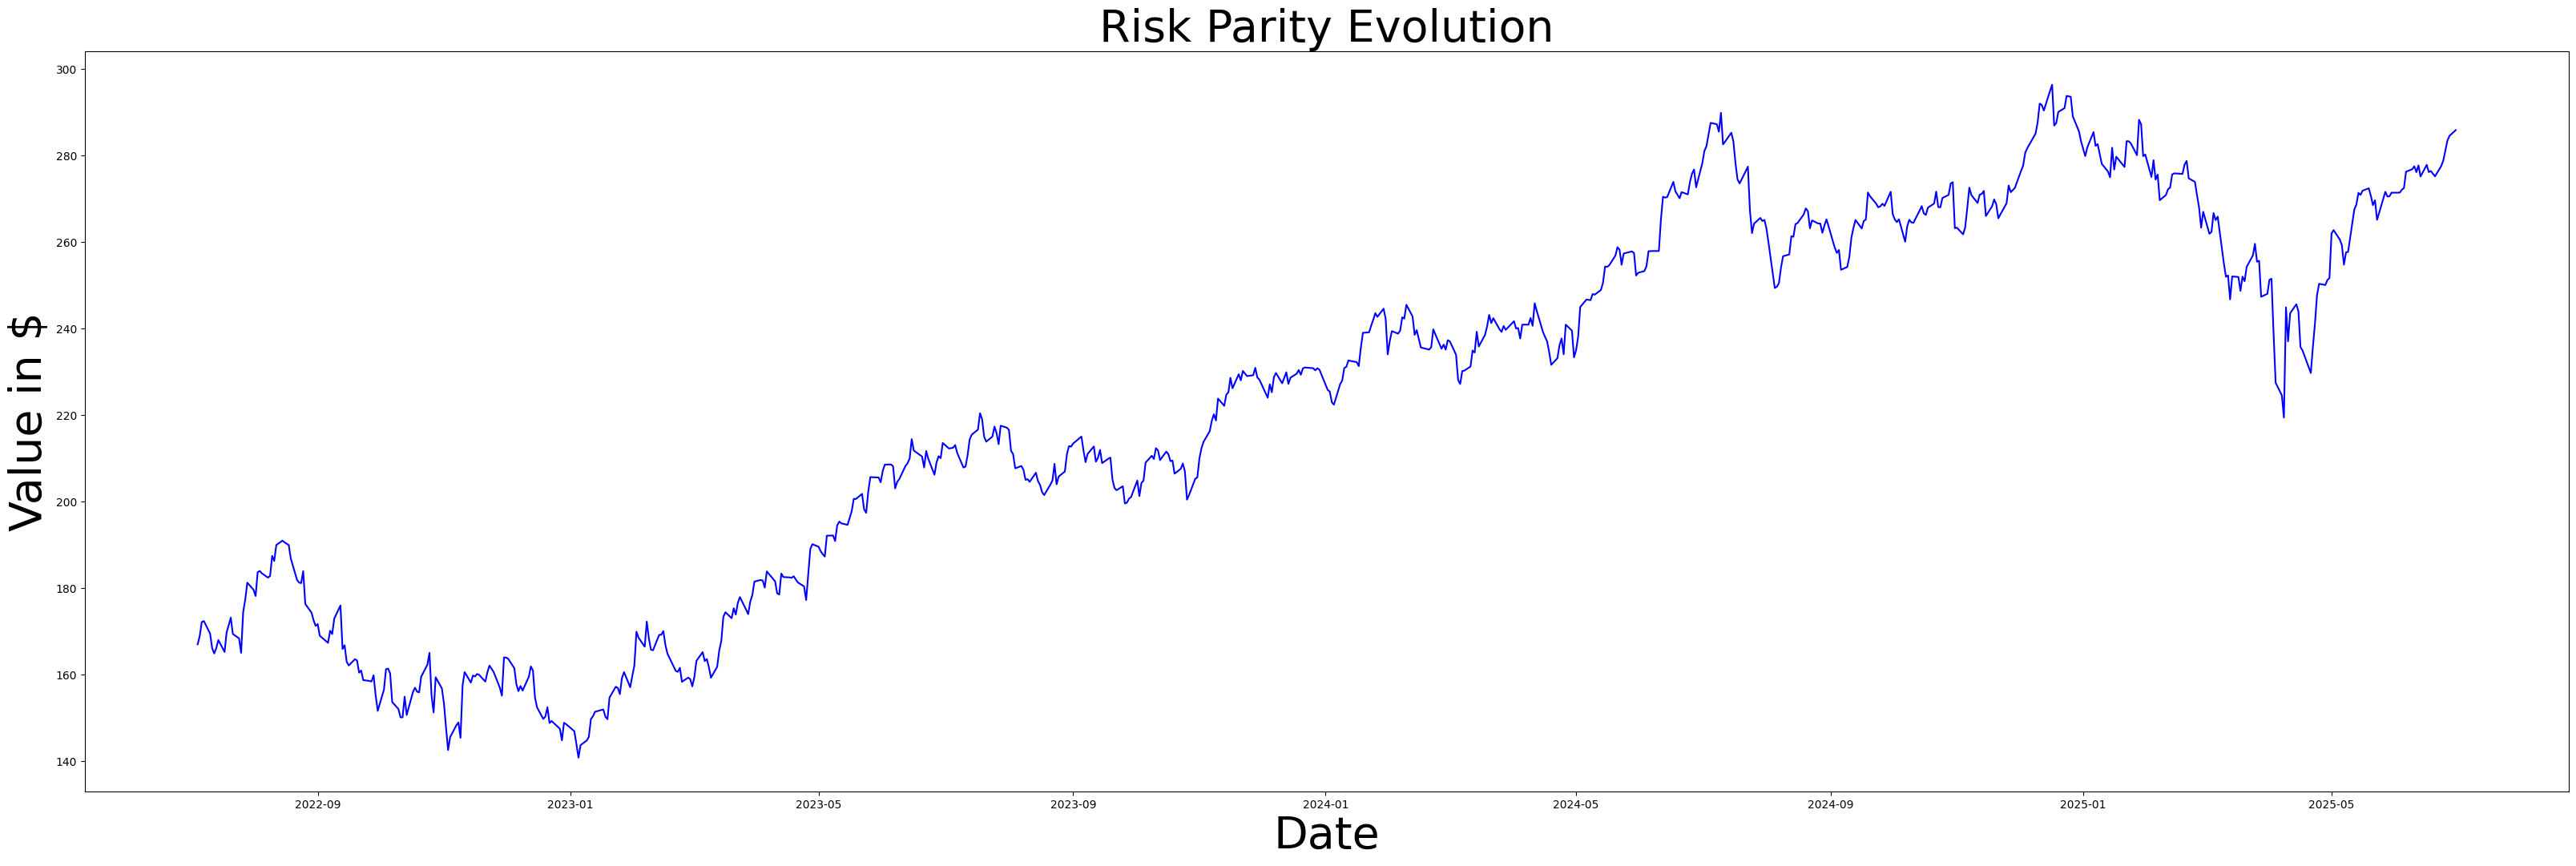

Total Return: 71.18%


In [24]:

rp_value, rp_return = analyzer.analyze_strategy('Risk Parity', risk_parity_weights, PORTFOLIO_EVOLUTION_YEARS)
plot_portfolio_evolution(rp_value, "Risk Parity Evolution")
print(f"Total Return: {rp_return:.2%}")


### Analyze Beta Weight Strategy

The **Beta Strategy** weights assets inversely to their market sensitivity (beta). 

**Strategy Logic**:
- Stocks with high beta (more volatile than market) get lower weights
- Stocks with low beta (less volatile than market) get higher weights
- Aims to create a portfolio with controlled market sensitivity

**Expected Benefits**:
- **Market Stability**: Portfolio should be less sensitive to broad market swings
- **Downside Protection**: May perform better during market downturns
- **Systematic Risk Management**: Addresses market-wide risk factors

[*********************100%***********************]  3 of 3 completed
d:\WORK_DIRECTORY\Roboport\app\analysis\portfolio_analyzer.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = (portfolio_value['Profit Close'][-1]/portfolio_value['Profit Close'][0])-1


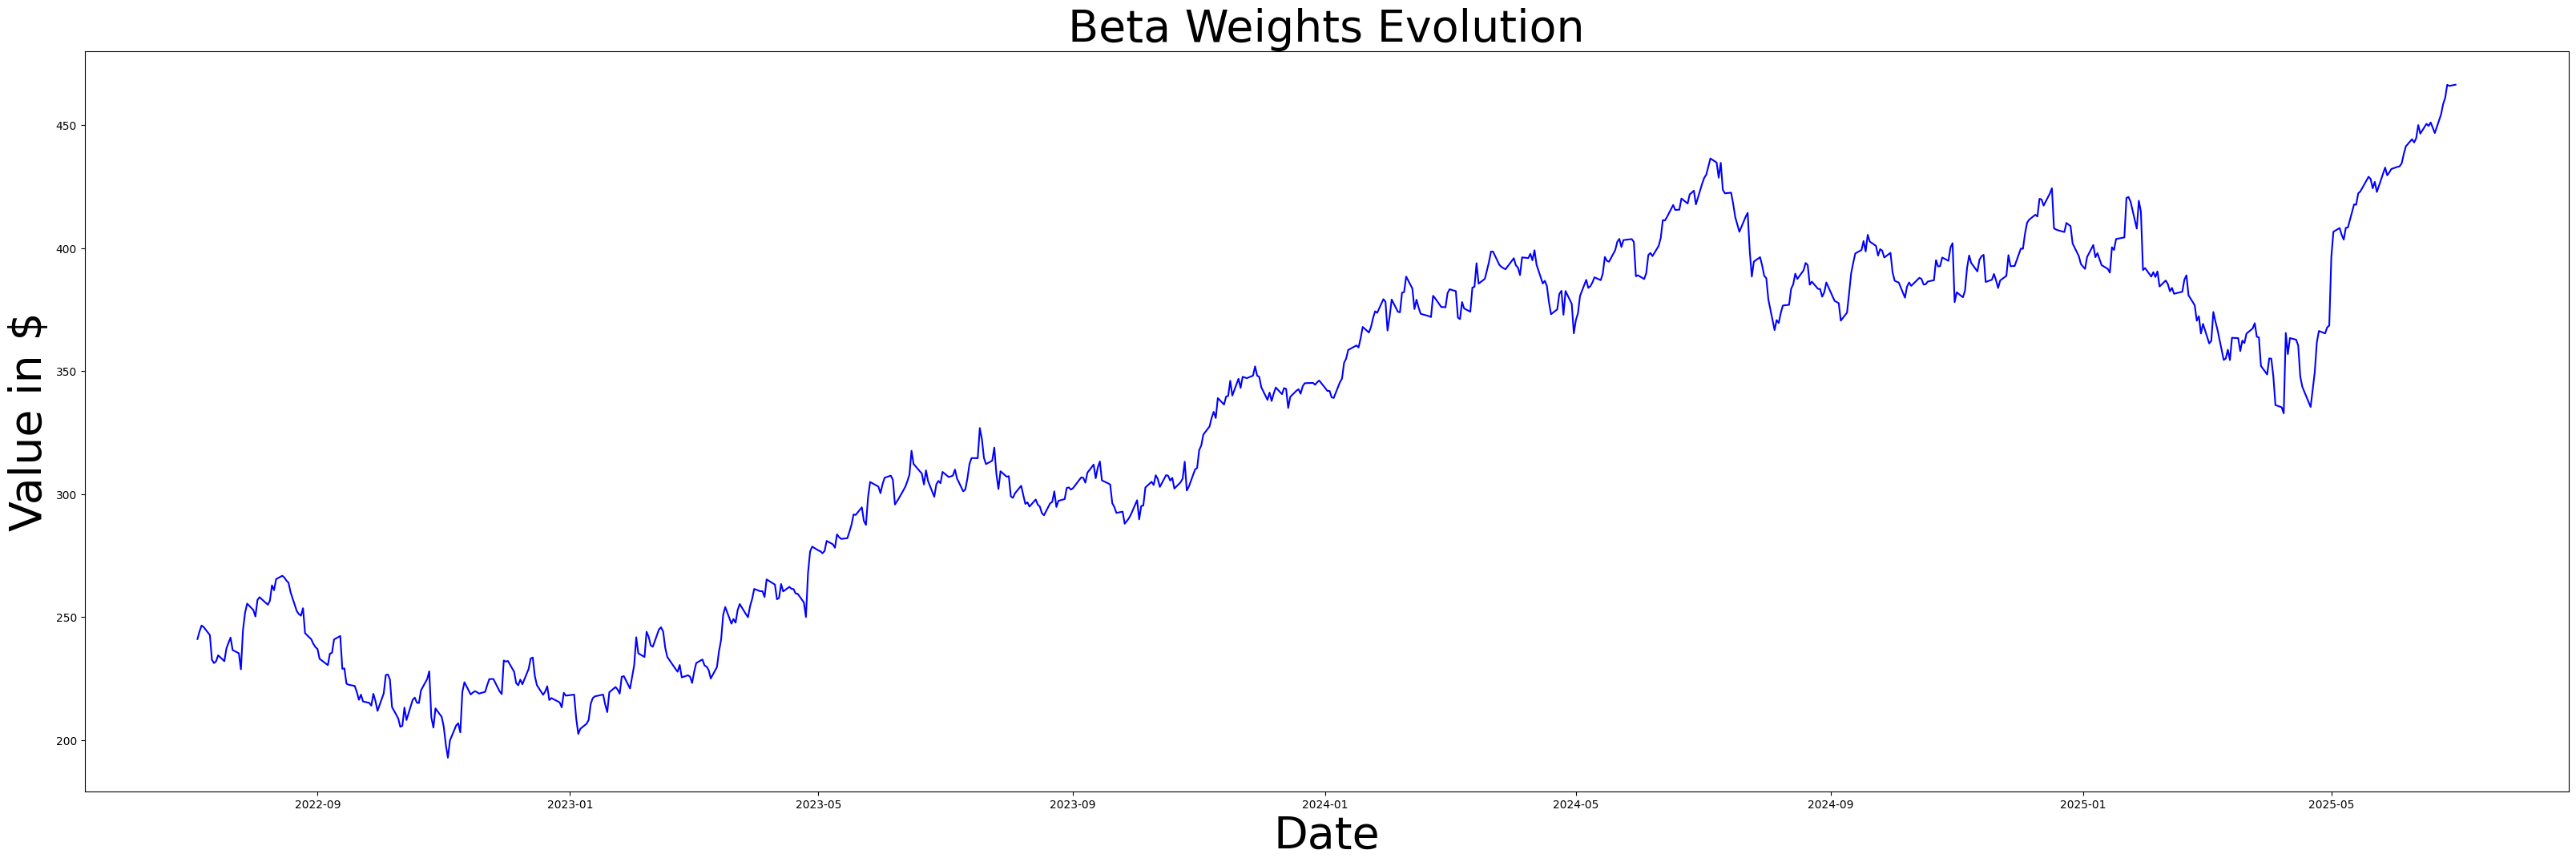

Total Return: 93.48%


In [25]:

beta_value, beta_return = analyzer.analyze_strategy('Beta', beta_weight, PORTFOLIO_EVOLUTION_YEARS)
plot_portfolio_evolution(beta_value, "Beta Weights Evolution")
print(f"Total Return: {beta_return:.2%}")


## Step 11: Sharpe Ratio Optimization

### What is the Sharpe Ratio?

The **Sharpe Ratio** is one of the most important metrics in finance. It measures **risk-adjusted return**:

```
Sharpe Ratio = (Portfolio Return - Risk-Free Rate) / Portfolio Volatility
```

### Why Optimize for Sharpe Ratio?

1. **Risk-Adjusted Performance**: A portfolio with 15% return and 10% volatility (Sharpe = 1.5) is better than one with 20% return and 20% volatility (Sharpe = 1.0)
2. **Practical Relevance**: Investors care about return per unit of risk taken
3. **Optimization Target**: Provides a single metric to maximize

### Monte Carlo Simulation Approach:

Since finding the optimal weights analytically is complex, we use **Monte Carlo simulation**:

1. **Generate Random Portfolios**: Create thousands of random weight combinations
2. **Calculate Metrics**: For each portfolio, compute return, volatility, and Sharpe ratio
3. **Find Optimal**: Select the portfolio with the highest Sharpe ratio
4. **Visualize**: Plot all portfolios to see the risk-return trade-off

### Mathematical Process:

For each random portfolio:
- **Expected Return**: `R = Σ(weight_i × mean_return_i)`
- **Portfolio Volatility**: `σ = √(w^T × Σ × w)` where Σ is the covariance matrix
- **Sharpe Ratio**: `SR = R / σ` (assuming risk-free rate ≈ 0)

### Expected Outcome:
The optimal portfolio should provide the best risk-adjusted returns based on historical data.

In [55]:
def calculate_sharpe_ratio_optimization(prices, num_tickers):
    """Calculate optimal portfolio weights using Sharpe ratio optimization via Monte Carlo simulation"""
    
    # Step 1: Calculate log returns (more stable for optimization)
    returns_marco = prices/(prices.shift(1))
    returns_marco.dropna(inplace=True)
    logreturns = np.log(returns_marco)
    
    # Step 2: Calculate expected returns and covariance matrix
    meanlog = logreturns.mean()  # Expected daily log returns
    sigma = logreturns.cov()     # Covariance matrix (risk relationships)
    
    
    # Step 3: Set up Monte Carlo simulation
    no_porfolio = NUMBER_OF_PORTFOLIOS
    
    # Arrays to store results
    test_weight = np.zeros((no_porfolio, num_tickers))
    test_return = np.zeros(no_porfolio)
    test_volatility = np.zeros(no_porfolio)
    sharpratio = np.zeros(no_porfolio)
    
    # Step 4: Monte Carlo simulation loop
    for k in range(no_porfolio):
        # Generate random weights that sum to 1
        random_weight = np.array(np.random.random(num_tickers))
        random_weight = random_weight/sum(random_weight)
        test_weight[k,:] = random_weight
        
        # Calculate portfolio expected return
        test_return[k] = np.sum(meanlog * random_weight) 
        
        # Calculate portfolio volatility using matrix multiplication
        # This captures both individual asset risk and correlations
        test_volatility[k] = np.sqrt(np.dot(random_weight.T, np.dot(sigma, random_weight)))
        
        # Calculate Sharpe ratio
        sharpratio[k] = test_return[k]/test_volatility[k]
    
    # Step 5: Find the portfolio with maximum Sharpe ratio
    max_sharpratio = sharpratio.argmax()
    sharpratio_weight = test_weight[max_sharpratio,:]
    
    return {
        'test_volatility': test_volatility,
        'test_return': test_return,
        'sharpratio': sharpratio,
        'max_sharpratio': max_sharpratio,
        'sharpratio_weight': sharpratio_weight,
        'meanlog': meanlog,
        'sigma': sigma
    }

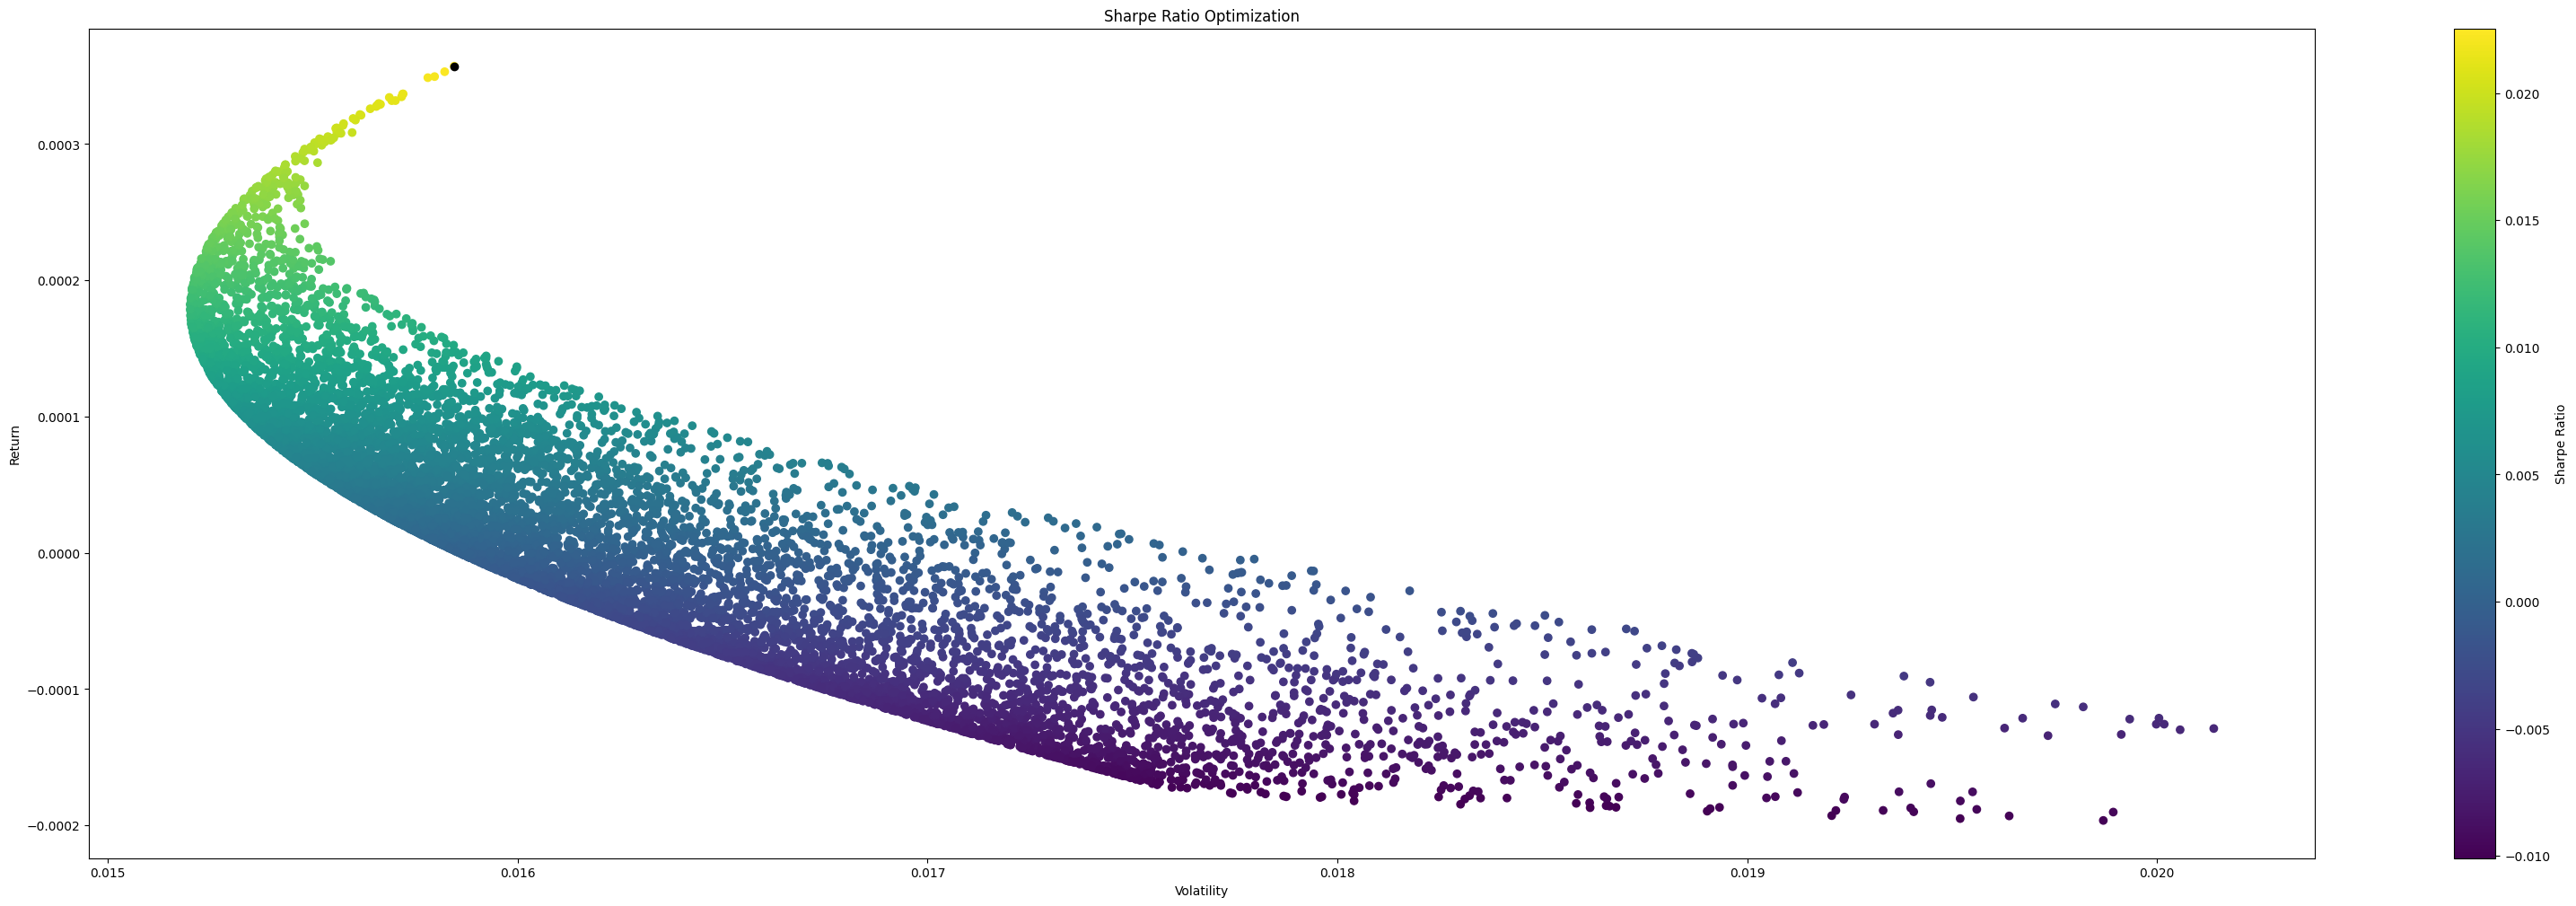

In [56]:

sharpe_data = calculate_sharpe_ratio_optimization(prices, num_tickers)
plot_sharpe_ratio_scatter(
    sharpe_data['test_volatility'], 
    sharpe_data['test_return'], 
    sharpe_data['sharpratio'], 
    sharpe_data['max_sharpratio']
)


### Understanding the Sharpe Ratio Scatter Plot

The scatter plot above shows:
- **X-axis**: Portfolio volatility (risk)
- **Y-axis**: Portfolio return
- **Color**: Sharpe ratio (darker = higher Sharpe ratio)
- **Red dot**: Optimal portfolio with highest Sharpe ratio

**Key Insights**:
- Portfolios in the upper-left (high return, low risk) are most desirable
- The optimal portfolio balances return and risk effectively
- You can see the natural trade-off between risk and return

[*********************100%***********************]  3 of 3 completed
d:\WORK_DIRECTORY\Roboport\app\analysis\portfolio_analyzer.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = (portfolio_value['Profit Close'][-1]/portfolio_value['Profit Close'][0])-1


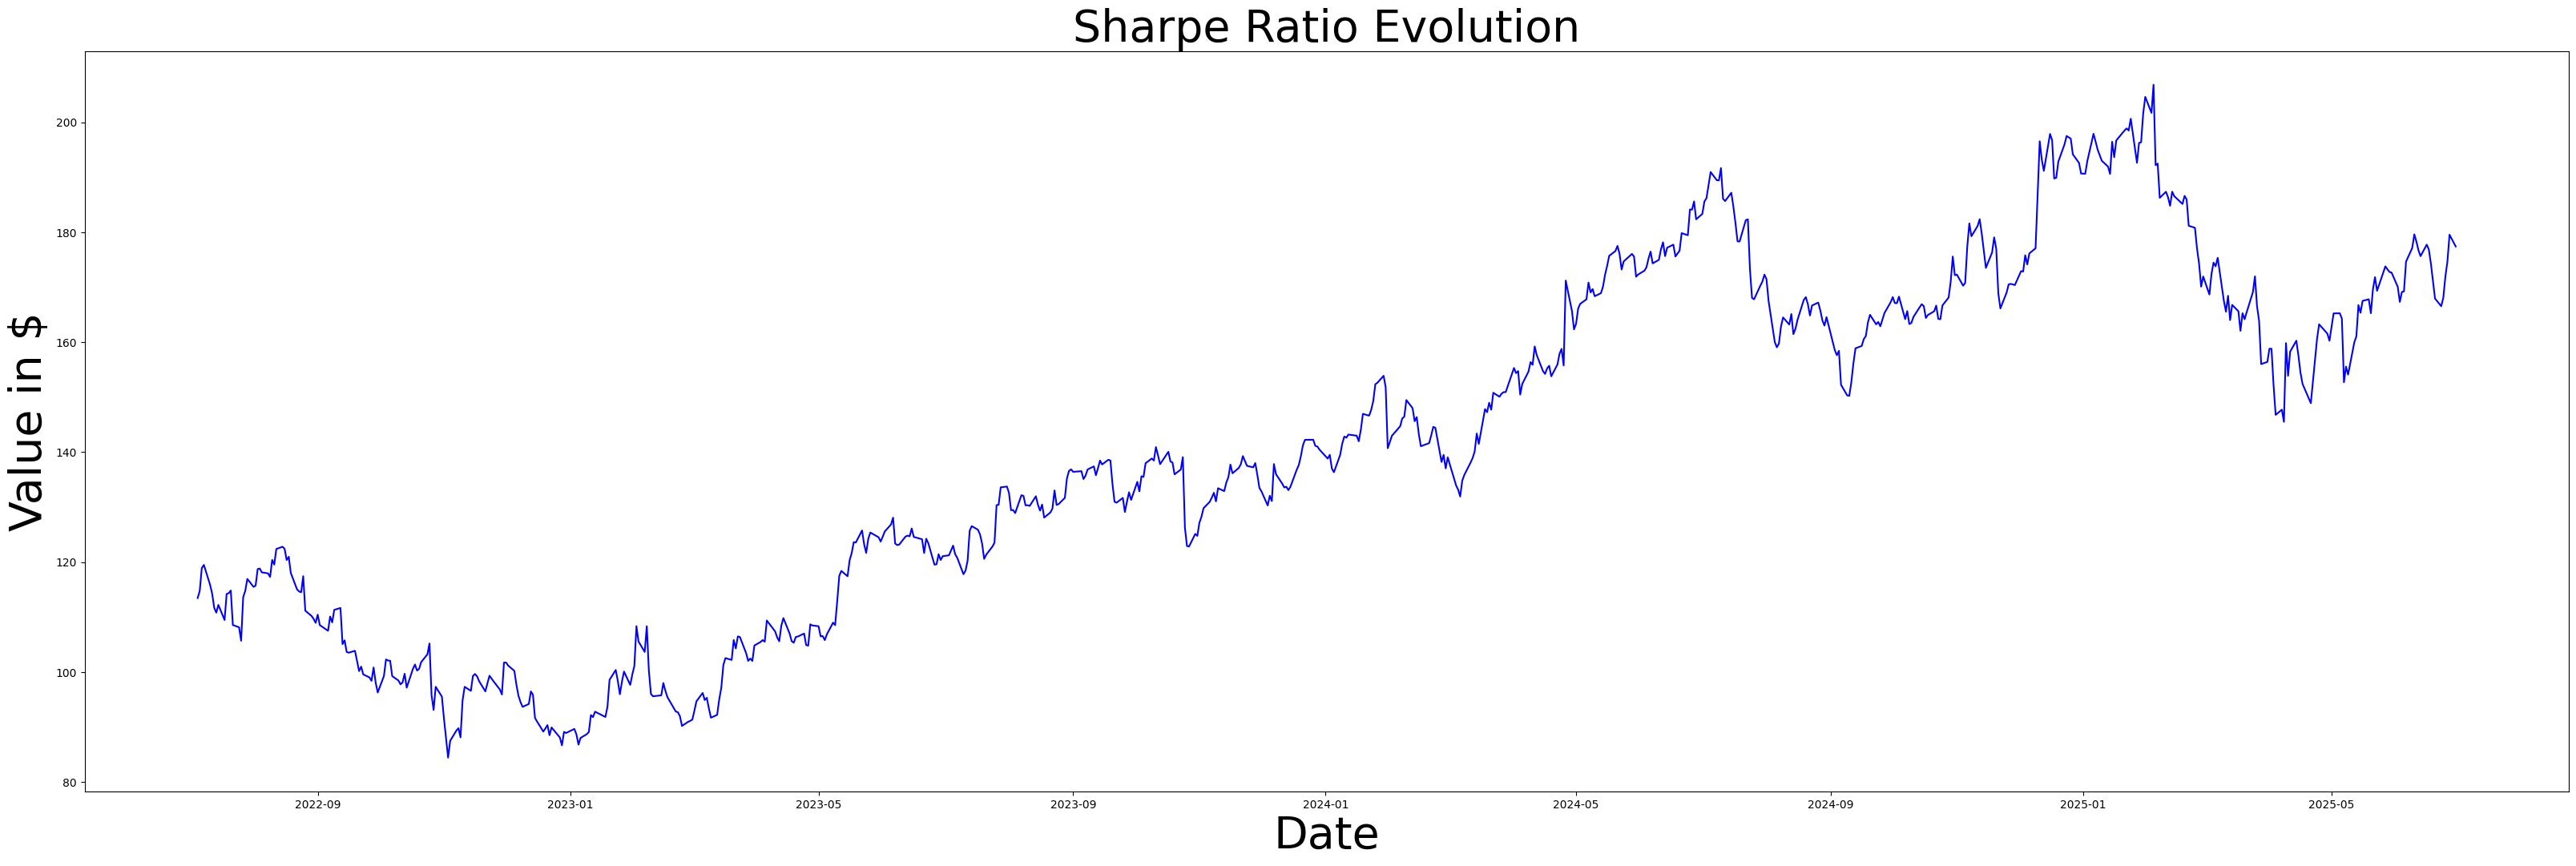

Total Return: 56.38%


In [28]:

sr_value, sr_return = analyzer.analyze_strategy('Sharp Ratio', sharpe_data['sharpratio_weight'], PORTFOLIO_EVOLUTION_YEARS)
plot_portfolio_evolution(sr_value, "Sharpe Ratio Evolution")
print(f"Total Return: {sr_return:.2%}")


## Step 12: Markowitz Optimization (Modern Portfolio Theory)

### What is Modern Portfolio Theory (MPT)?

**Modern Portfolio Theory**, developed by Harry Markowitz in 1952, is the foundation of modern portfolio management. It won him the Nobel Prize in Economics.

### Key Concepts:

1. **Efficient Frontier**: The set of portfolios that offer the highest expected return for each level of risk
2. **Optimization**: Uses mathematical optimization to find the best portfolios
3. **Risk-Return Trade-off**: Formalizes the relationship between risk and expected return
4. **Diversification**: Quantifies the benefits of diversification through correlation

### The Optimization Problem:

Markowitz optimization solves two related problems:

1. **Maximum Sharpe Ratio**: Find weights that maximize return per unit of risk
2. **Efficient Frontier**: For each target return level, find the minimum risk portfolio

### Mathematical Formulation:

**Objective Function**: Maximize Sharpe Ratio
```
Maximize: (w^T × μ) / √(w^T × Σ × w)
```

**Constraints**:
- Weights sum to 1: `Σw_i = 1`
- No short selling: `w_i ≥ 0`

Where:
- `w` = vector of portfolio weights
- `μ` = vector of expected returns
- `Σ` = covariance matrix

### Why Use Markowitz Over Monte Carlo?

1. **Guaranteed Optimality**: Finds the true mathematical optimum
2. **Efficient Frontier**: Provides the complete set of optimal portfolios
3. **Theoretical Foundation**: Based on rigorous mathematical theory
4. **Industry Standard**: Widely used in professional portfolio management

### How Our Implementation Works

Our code implements two key optimizations:

1. **Maximum Sharpe Ratio Portfolio**: Finds weights that maximize return per unit of risk
2. **Efficient Frontier**: Calculates minimum variance for each target return level

### Optimization Constraints

- **Budget Constraint**: All weights must sum to 1 (Σwi = 1)
- **Long-Only**: All weights must be non-negative (wi ≥ 0)
- **Return Target**: For efficient frontier, we constrain expected return to specific levels

### Why Use Scipy's SLSQP Method?

**Sequential Least Squares Programming (SLSQP)** is ideal for our problem because:
- Handles equality and inequality constraints efficiently
- Works well with non-linear objective functions
- Robust convergence for portfolio optimization problems

### The Efficient Frontier:

The efficient frontier shows all portfolios that maximize return for a given level of risk. It's curved because:
- **Diversification Benefits**: Combining assets reduces risk through correlation
- **Diminishing Returns**: Adding more assets provides decreasing marginal benefits
- **Risk-Return Trade-off**: Higher returns require accepting higher risk

In [57]:
def calculate_markowitz_optimization(meanlog, sigma, num_tickers, test_return):
    """Calculate Markowitz optimal portfolio"""
    def negative_sharpratio(random_weight):
        random_weights = np.array(random_weight)
        R = np.sum(meanlog*random_weights)
        V = np.sqrt(np.dot(random_weight.T, np.dot(sigma, random_weights)))
        SR = R/V
        return -SR
    
    def checksumtoone(random_weight):
        return np.sum(random_weight)-1
    
    w_0 = [1/num_tickers for _ in range(num_tickers)]
    bounds = [(0,1) for _ in range(num_tickers)]
    constraints = ({'type':'eq','fun':checksumtoone})
    optimal_weight = minimize(negative_sharpratio, w_0, method='SLSQP', bounds=bounds, constraints=constraints)
    
    # Calculate efficient frontier
    returns = np.linspace(0, max(test_return), 50)
    optimal_volatility = []  
    
    def minmizevolatility(random_weight):
        random_weights = np.array(random_weight)
        V = np.sqrt(np.dot(random_weight.T, np.dot(sigma, random_weights)))
        return V
    
    def getreturn(w):
        w = np.array(w)
        R = np.sum(meanlog*w)
        return R

    for r in returns:
        #find best volatility
        constraints = ({'type':'eq','fun':checksumtoone},{'type':'eq','fun': lambda random_weight: getreturn(random_weight)- r})
        optimal = minimize(minmizevolatility, w_0, method='SLSQP', bounds=bounds, constraints=constraints)
        optimal_volatility.append(optimal['fun'])
    
    return {
        'optimal_weight': optimal_weight,
        'returns': returns,
        'optimal_volatility': optimal_volatility
    }

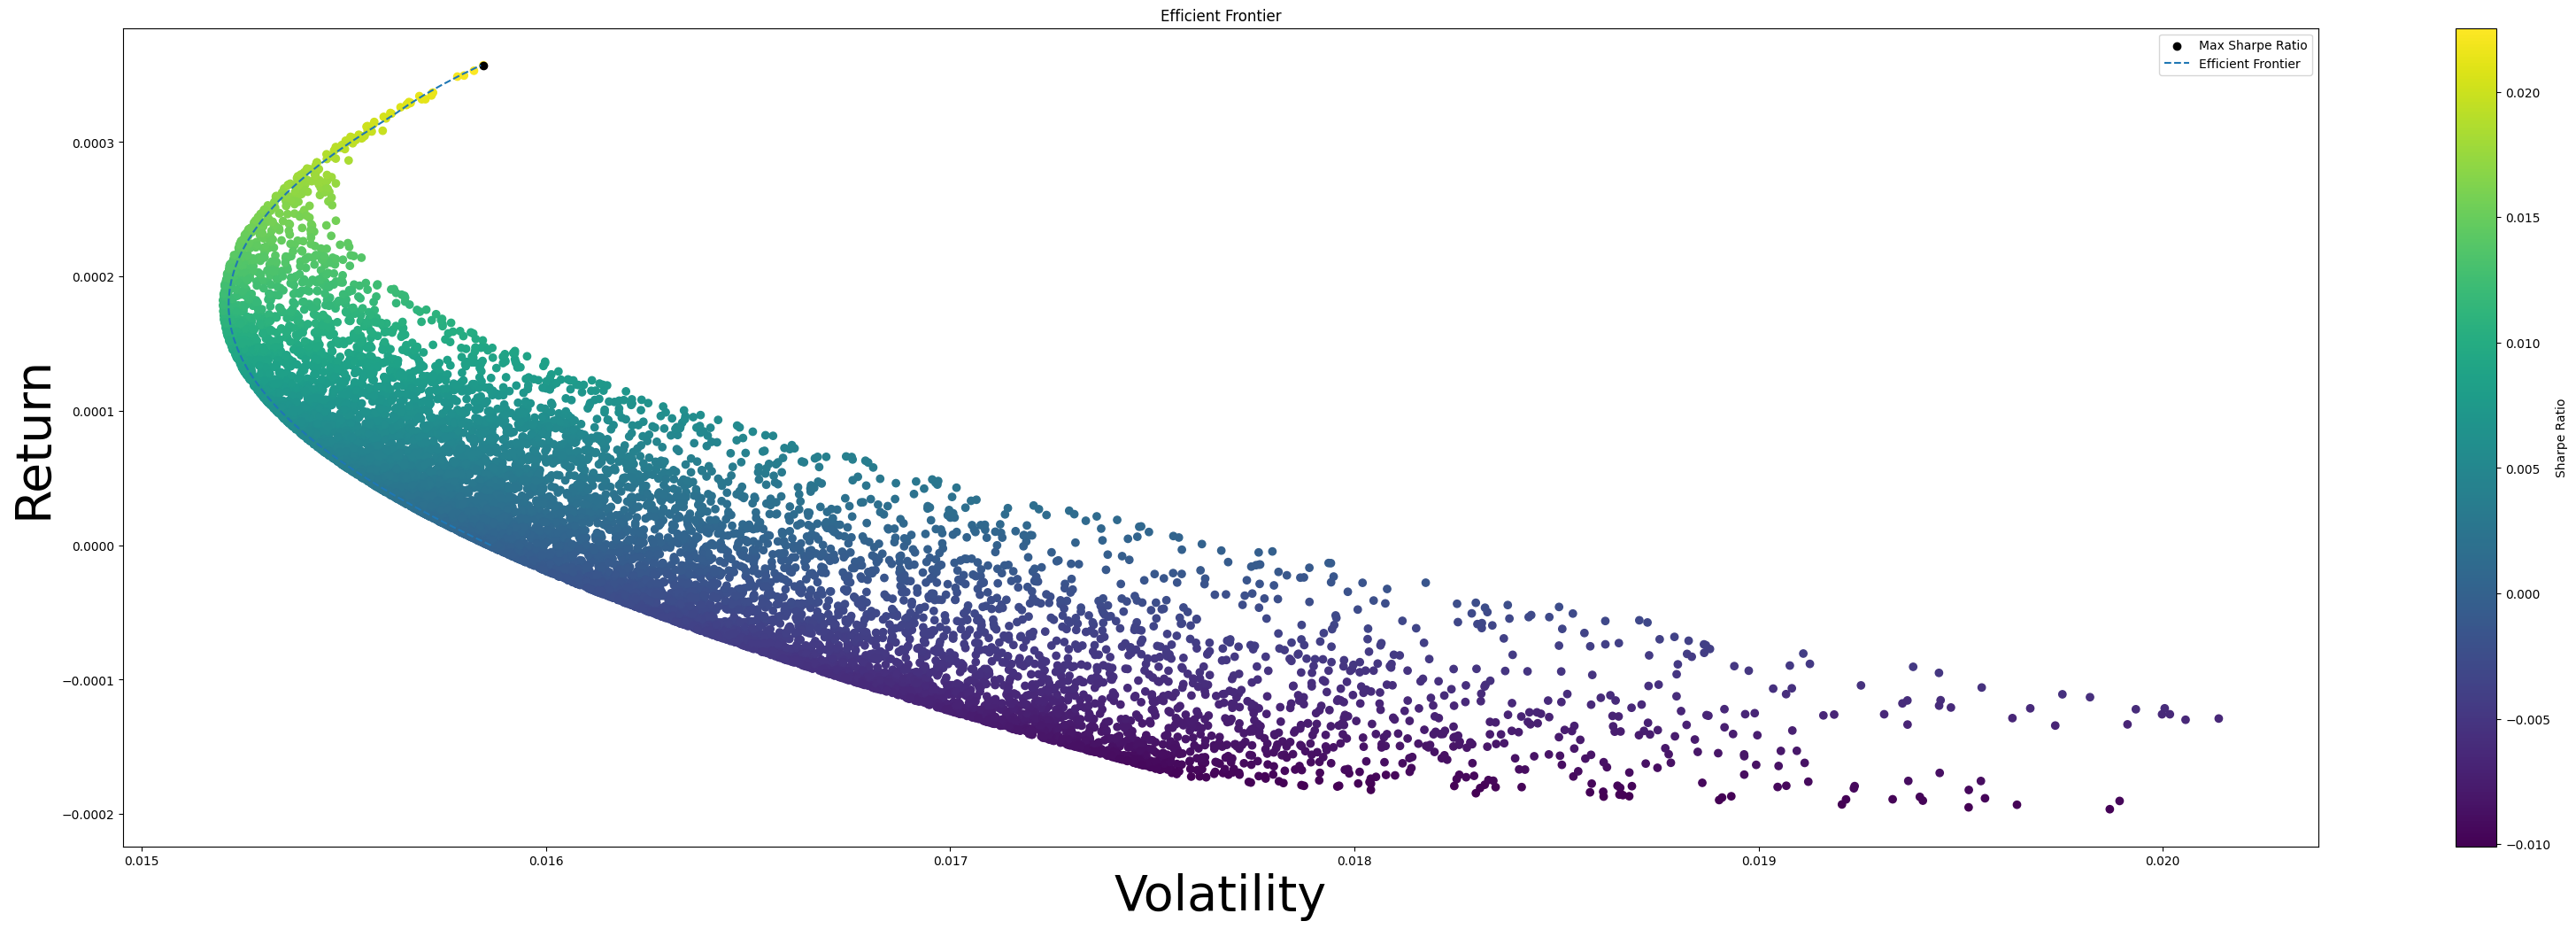

In [58]:

markowitz_data = calculate_markowitz_optimization(
    sharpe_data['meanlog'], 
    sharpe_data['sigma'], 
    num_tickers, 
    sharpe_data['test_return']
)
plot_efficient_frontier(
    sharpe_data['test_volatility'],
    sharpe_data['test_return'],
    sharpe_data['sharpratio'],
    sharpe_data['max_sharpratio'],
    markowitz_data['optimal_volatility'],
    markowitz_data['returns']
)


### Understanding the Efficient Frontier Plot

This plot combines our Monte Carlo simulation with the Markowitz efficient frontier:

- **Scattered Dots**: Random portfolios from Monte Carlo (colored by Sharpe ratio)
- **Red Line**: The efficient frontier - mathematically optimal portfolios
- **Red Dot**: Maximum Sharpe ratio portfolio from Monte Carlo
- **Curve Shape**: Shows the risk-return trade-off

**Key Insights**:
1. **Frontier Dominance**: Portfolios on the efficient frontier are superior to all others
2. **Optimization Quality**: Shows how close our Monte Carlo result is to the true optimum
3. **Investment Choices**: Any portfolio below the frontier is sub-optimal
4. **Risk-Return Relationship**: Higher returns require accepting higher risk

[*********************100%***********************]  3 of 3 completed
d:\WORK_DIRECTORY\Roboport\app\analysis\portfolio_analyzer.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = (portfolio_value['Profit Close'][-1]/portfolio_value['Profit Close'][0])-1


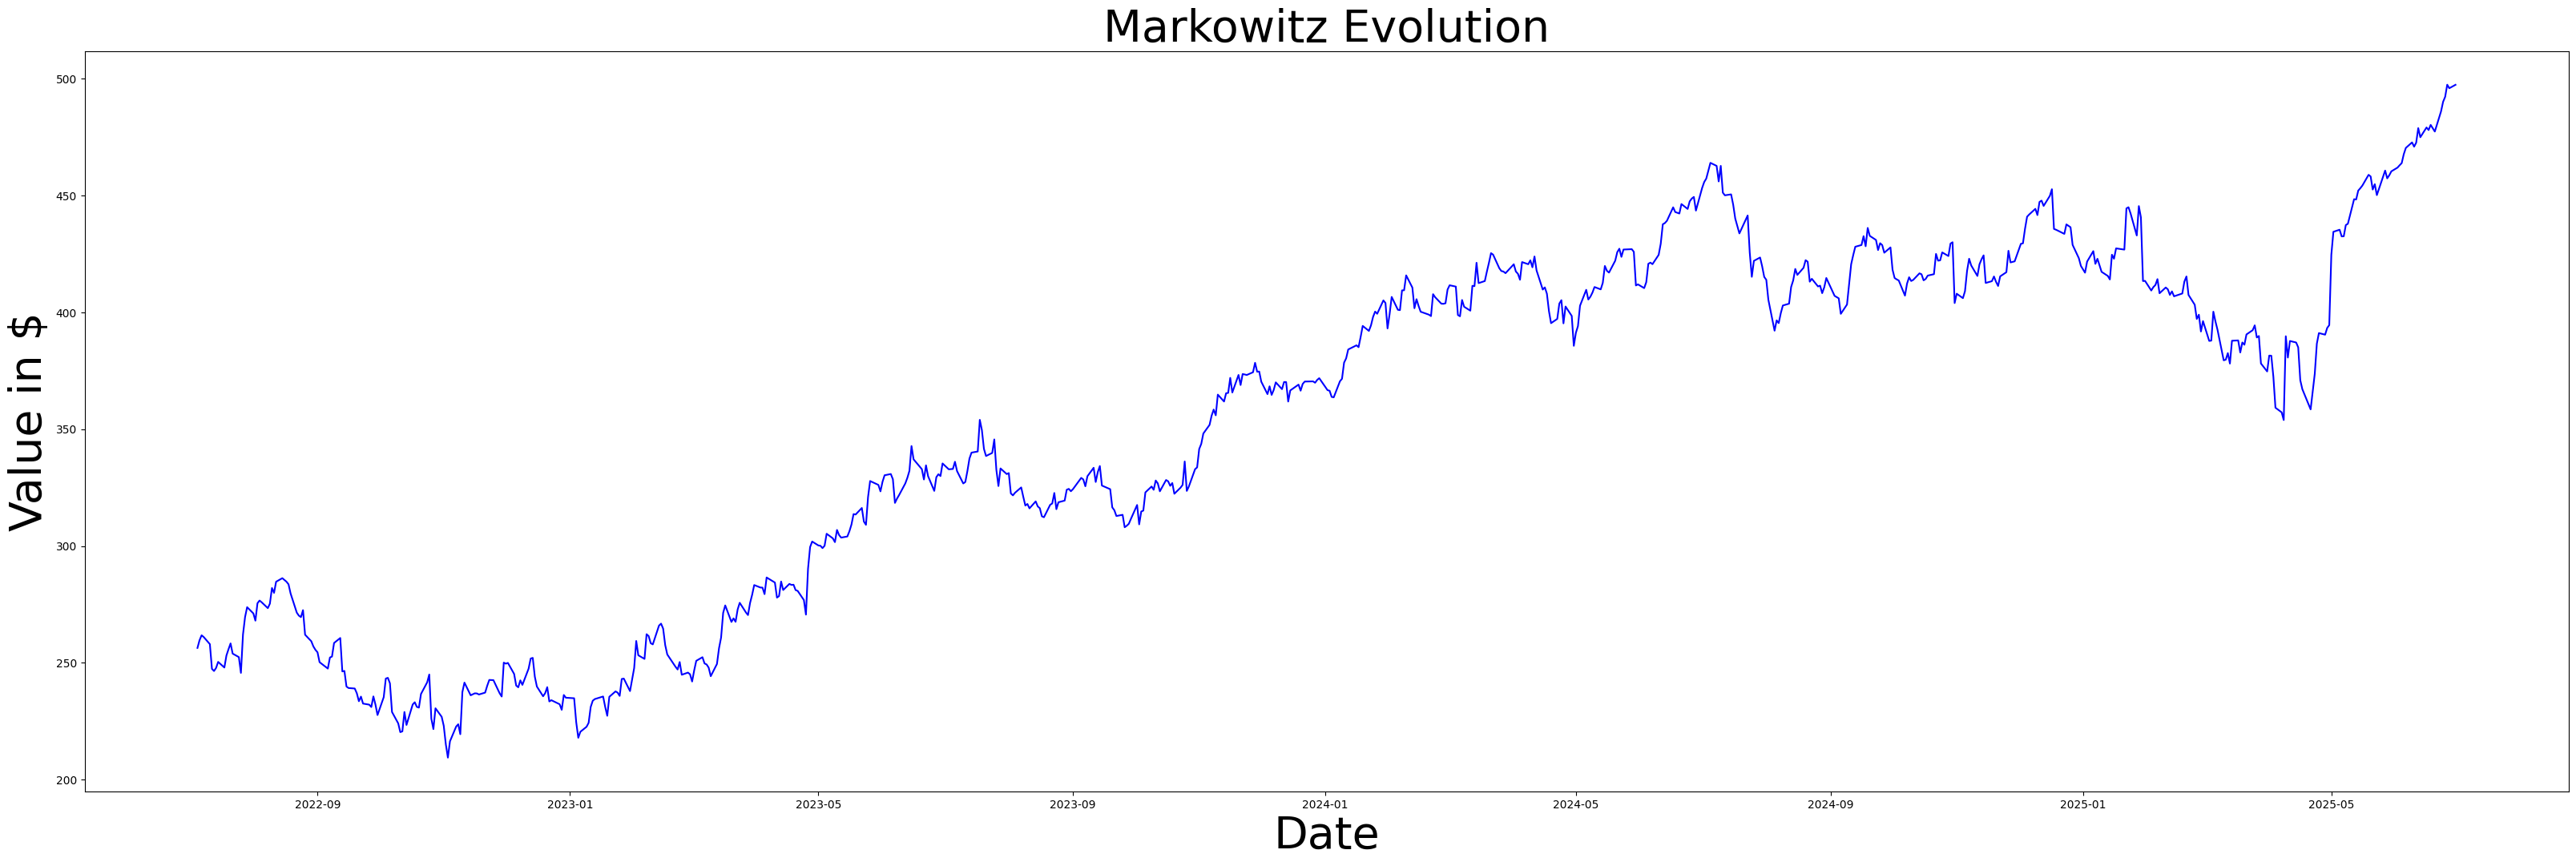

Total Return: 94.04%


In [59]:

markowitz_value, markowitz_return = analyzer.analyze_strategy('Markowitz', markowitz_data['optimal_weight'].x, PORTFOLIO_EVOLUTION_YEARS)
plot_portfolio_evolution(markowitz_value, "Markowitz Evolution")
print(f"Total Return: {markowitz_return:.2%}")


### Analyzing Markowitz Portfolio Performance

The evolution plot above shows how the Markowitz-optimized portfolio would have performed over the specified time period. Key aspects to analyze:

**Performance Characteristics:**
- **Steady Growth**: Optimized portfolios often show more consistent growth patterns
- **Reduced Volatility**: Better diversification typically leads to smoother return curves
- **Drawdown Management**: Maximum Sharpe ratio portfolios often have smaller maximum drawdowns

**Limitations to Consider:**
1. **Historical Bias**: Optimization is based on historical data which may not predict future performance
2. **Transaction Costs**: Real-world implementation involves trading costs not captured in backtesting
3. **Rebalancing**: Optimal weights change over time, requiring periodic portfolio rebalancing
4. **Market Regimes**: Different market conditions may favor different optimization approaches

## Step 13: Final Strategy Recommendation

### Comprehensive Strategy Evaluation Framework

Our final recommendation system compares multiple portfolio optimization strategies to identify the best performer. This approach acknowledges that different strategies may perform better under different market conditions.

### Strategies Being Compared

1. **User Strategy**: Original allocation based on investor preferences
2. **Risk Parity**: Equal risk contribution from each asset
3. **Beta Weighting**: Weights inversely proportional to systematic risk
4. **Sharpe Ratio Optimization**: Monte Carlo approach to maximize risk-adjusted returns
5. **Markowitz Optimization**: Mathematical optimization using Modern Portfolio Theory

### Evaluation Methodology

**Backtesting Process:**
- Each strategy is backtested over the same historical period
- Performance is measured using total return over the investment horizon
- The strategy with the highest total return is selected as optimal

**Important Considerations:**
- **Survivorship Bias**: We only analyze successful, liquid stocks
- **Look-Ahead Bias**: Strategies are optimized using the full historical period
- **Market Regime**: Performance may vary significantly across different market cycles

### Why Total Return as the Primary Metric?

While total return is our primary selection criterion, in practice, investors should consider:
- **Risk-Adjusted Returns**: Sharpe ratio, Sortino ratio, Maximum Drawdown
- **Volatility**: Standard deviation of returns
- **Correlation**: How the portfolio moves relative to benchmarks
- **Tail Risk**: Performance during extreme market events

### Strategic Allocation Insights

The recommended allocation provides several key insights:
- **Diversification Benefits**: How optimization changes from naive equal weighting
- **Risk Concentration**: Which assets contribute most to portfolio risk
- **Return Drivers**: Which assets provide the highest expected returns
- **Correlation Effects**: How asset relationships influence optimal weights

In [60]:

best_strategy, best_return = analyzer.get_best_strategy()
print(f"Best Strategy: {best_strategy} with return {best_return:.2%}")


Best Strategy: Markowitz with return 94.04%


### Interpreting the Recommendation

The output above shows which strategy achieved the highest total return during our backtesting period. However, investors should consider several factors when implementing this recommendation:

**Implementation Considerations:**

1. **Rebalancing Frequency**: How often should the portfolio be adjusted to maintain optimal weights?
2. **Transaction Costs**: What are the trading costs associated with implementing and maintaining this strategy?
3. **Tax Implications**: How do capital gains taxes affect the net performance?
4. **Market Impact**: For large portfolios, how does trading affect market prices?

**Risk Management:**

1. **Concentration Risk**: Is the recommended portfolio overly concentrated in specific assets?
2. **Market Beta**: How sensitive is the portfolio to overall market movements?
3. **Sector Exposure**: Are there unwanted concentrations in specific industries?
4. **Liquidity Risk**: Can positions be easily liquidated during market stress?

**Behavioral Finance Considerations:**

1. **Investor Comfort**: Can the investor psychologically handle the recommended strategy?
2. **Time Horizon**: Does the strategy align with the investor's investment timeline?
3. **Risk Tolerance**: Is the volatility acceptable to the investor?
4. **Investment Goals**: Does the strategy support the investor's financial objectives?

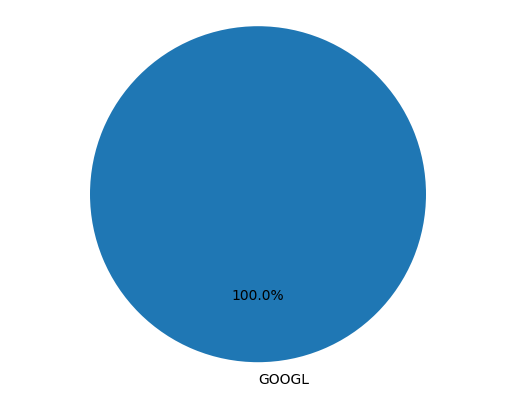

,Key,Value
0,AAPL,0.000000e+00
1,MSFT,7.632783e-17
2,GOOGL,1.000000e+00


In [61]:

# Display corresponding pie chart and weights
if best_strategy == 'Risk Parity':
    create_pie_chart(risk_parity_weights, tickers)
    df = analyzer.create_recommendation_dataframe(best_strategy, risk_parity_weights)
elif best_strategy == 'Markowitz':
    create_pie_chart(markowitz_data['optimal_weight'].x, tickers)
    df = analyzer.create_recommendation_dataframe(best_strategy, markowitz_data['optimal_weight'].x)
elif best_strategy == 'User':
    create_pie_chart(weights, tickers)
    df = analyzer.create_recommendation_dataframe(best_strategy, weights)
elif best_strategy == 'Beta':
    create_pie_chart(beta_weight, tickers)
    df = analyzer.create_recommendation_dataframe(best_strategy, beta_weight)
elif best_strategy == 'Sharp Ratio':
    create_pie_chart(sharpe_data['sharpratio_weight'], tickers)
    df = analyzer.create_recommendation_dataframe(best_strategy, sharpe_data['sharpratio_weight'])

df


### Understanding the Final Allocation

The pie chart and dataframe above provide the concrete implementation details for your optimized portfolio:

**Allocation Analysis:**

1. **Weight Distribution**: How the optimization algorithm allocates capital across assets
2. **Diversification Level**: Whether the portfolio is well-diversified or concentrated
3. **Risk-Return Balance**: How weights reflect each asset's risk-return characteristics
4. **Correlation Benefits**: How weights exploit correlation patterns for diversification

### Conclusion

This portfolio optimization framework provides a quantitative approach to asset allocation, combining multiple established financial theories and optimization techniques.The combination of quantitative optimization with qualitative judgment provides the best foundation for long-term investment success.